# Soundscapes, Figures 2-4, Table 1-2

Import libraries and processing scripts:

In [1]:
import json
import numpy as np
import sys
import pickle
from nltk import sent_tokenize, word_tokenize
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pyprind
import pandas as pd
sys.path.insert(0, 'utils/')
from syllabipymhg import syllabipymhg
from util import cleantext, process_soundscapes

Import data and lemmatizer:

In [2]:
data = json.load(open("data/lyrik_dict.json"))
tagger = pickle.load(open("utils/lemmatizer.pkl", "rb"))

Remove duplicate, 14th century, and Latin texts:

In [3]:
del data["MSG"]  # ENHG
del data["MSW"]  # ENHG
del data["OVW"]  # ENHG
del data["NEIC"]  # duplicate
del data["NEIM"]  # duplicate
del data["NEIR"]  # duplicate
del data["MRL"]  # latin

Summary Statistics:

In [4]:
sylls_per_stanza = []
sylls_per_line = []
lines_per_stanza = []
stanzas = 0

for k in list(data.keys()):
    
    text = data[k]
    
    stanza_text = text.split('\n\n')

    stanzas_lines = [stanza.split('\n') for stanza in stanza_text]
    stanza_lengths = [len(l) for l in stanzas_lines]
    stanzas_words = [[cleantext(line).split()
                      for line in stanza] for stanza in stanzas_lines]

    stanzas_words_sylls = [[[syllabipymhg(
        word) for word in line] for line in stanza] for stanza in stanzas_words]
    
    stanzas += len(stanzas_words_sylls)
    
    for stanza in stanzas_words_sylls:
        if 1 < len(stanza) <= 50:
            lines_per_stanza.append(len(stanza))
            sylls = 0
            for l in stanza:
                sylls_per_line.append(len([item for sublist in l for item in sublist]))
                sylls += len([item for sublist in l for item in sublist])
            sylls_per_stanza.append(sylls)

For Table 1:

In [5]:
print("Table 1")
print("*"*20)
print()
print("Number of stanzas:")
print(stanzas)
print()
print("Median syllables per stanza:")
print(np.median(sylls_per_stanza))
print()
print("Median lines per stanza:")
print(np.median(lines_per_stanza))
print()
print("Median syllables per line:")
print(np.median(sylls_per_line))
print()

Table 1
********************

Number of stanzas:
7856

Median syllables per stanza:
81.0

Median lines per stanza:
9.0

Median syllables per line:
8.0



Function to get lemmas from stanzas:

In [6]:
def get_lemma_string(text_string):
    sents = sent_tokenize(text_string.lower())
    words = [word_tokenize(s) for s in sents]
    lemma_string = ""
    for s in words:
        tagged = tagger.tag(s)
        for tup in tagged:
            if tup[1] is not None:
                lemma_string += tup[1] + " "
            else:
                lemma_string += tup[0] + " "
        
    return lemma_string

Create and fill buckets:

In [7]:
buckets = {"20": {"bucket": [],
                  "count": 0},
           "25": {"bucket": [],
                  "count": 0},
           "30": {"bucket": [],
                  "count": 0},
           "35": {"bucket": [],
                  "count": 0},
           "40": {"bucket": [],
                  "count": 0},
           "45": {"bucket": [],
                  "count": 0},
           "45+": {"bucket": [],
                  "count": 0}
           }


all_percents = []
for k in data.keys():
    text = data[k]
    processed = process_soundscapes(stanza_text=text)
    processed = [x for x in processed[2] if "\n" in x[0]]
    for t in processed:
        
        if 1 < len(t[0].split("\n")) <= 50:

            all_percents.append(t[1])
        
            if t[1] < .2:
                buckets["20"]["bucket"].append(get_lemma_string(t[0]))
                buckets["20"]["count"] += 1

            elif t[1] < .25:
                buckets["25"]["bucket"].append(get_lemma_string(t[0]))
                buckets["25"]["count"] += 1

            elif t[1] < .3:
                buckets["30"]["bucket"].append(get_lemma_string(t[0]))
                buckets["30"]["count"] += 1

            elif t[1] < .35:
                buckets["35"]["bucket"].append(get_lemma_string(t[0]))
                buckets["35"]["count"] += 1

            elif t[1] < .4:
                buckets["40"]["bucket"].append(get_lemma_string(t[0]))
                buckets["40"]["count"] += 1

            elif t[1] < .45:
                buckets["45"]["bucket"].append(get_lemma_string(t[0]))
                buckets["45"]["count"] += 1

            else:
                buckets["45+"]["bucket"].append(get_lemma_string(t[0]))
                buckets["45+"]["count"] += 1

Plot bucket distribution:

/Users/chench/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


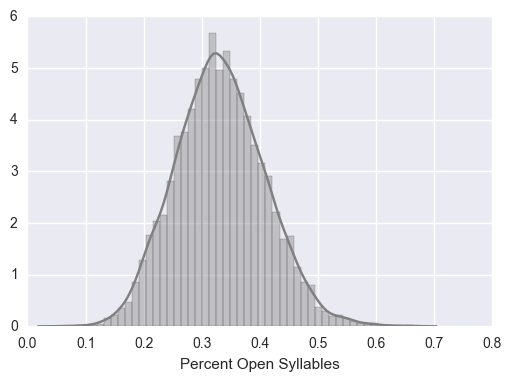

In [8]:
% matplotlib inline
ax = sns.distplot(all_percents, axlabel="Percent Open Syllables", color='gray')

Bucket counts:

In [9]:
for k in sorted(list(buckets.keys())):
    print(k, buckets[k]['count'])

20 272
25 803
30 1582
35 2055
40 1592
45 974
45+ 516


In [10]:
print("Median percent open syllables (Table 1):")
print(np.median(all_percents))

Median percent open syllables (Table 1):
0.328767123288


Bootstrap:

In [11]:
np.random.seed(10)

bootstrapped = {"20": {},
                "25": {},
                "30": {},
                "35": {},
                "40": {},
                "45": {},
                "45+": {}
               }

for k in bootstrapped.keys():
    bootstrapped[k] = {"ich": [],
                       "er": [],
                       "sie": [],
                       "wir": [],
                       "dû": [],
                       "daz": [],
                       "der": [],
                       "die": []}

for b in buckets.keys():
    
    subset = len(buckets[b]["bucket"])
    
    bar = pyprind.ProgBar(1000, monitor=True, bar_char="#")
    for n in range(1000):  # num of boot strap samples

        sample = ""
        for i in range(subset):
            sample_num = np.random.randint(0, subset)
            sample += buckets[b]["bucket"][sample_num] + "\n"

        for p in punctuation:
            sample = sample.replace(p, "")
        tokens = word_tokenize(sample) 
        freq = Counter(tokens).most_common()
        total_toks = sum([x[1] for x in freq])
        rel_freq = []
        for tup in freq:
            rel_freq.append((tup[0], tup[1]/total_toks))
        
        for word in ["ich", "er", "sie", "dû", "wir", "daz", "der", "die"]:
            if word in dict(rel_freq):
                bootstrapped[b][word].append(dict(rel_freq)[word])
            else:
                bootstrapped[b][word].append(0)

        bar.update()
        

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:04:20
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:01:22
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:08:09
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:03:52
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:01:47
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:07:00
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:09:53


Get percentiles:

In [12]:
ordered_keys = ["20", "25", "30", "35", "40", "45", "45+"]

for b in ordered_keys:
    print(b, np.percentile(bootstrapped[b]["ich"], 2.5), np.percentile(bootstrapped[b]["ich"], 50), np.percentile(bootstrapped[b]["ich"], 97.5))

20 0.0357825487917 0.0417154616787 0.0480503015884
25 0.0428205017438 0.0464462461023 0.0502467490689
30 0.0471552334606 0.0497730236513 0.0523130337213
35 0.0562681530621 0.0588136160478 0.0613226467685
40 0.0660710029769 0.0692494125368 0.0722019406847
45 0.0697230445231 0.0731068646225 0.07676707792
45+ 0.0738455448637 0.0787010780251 0.0835951493488


Plot:

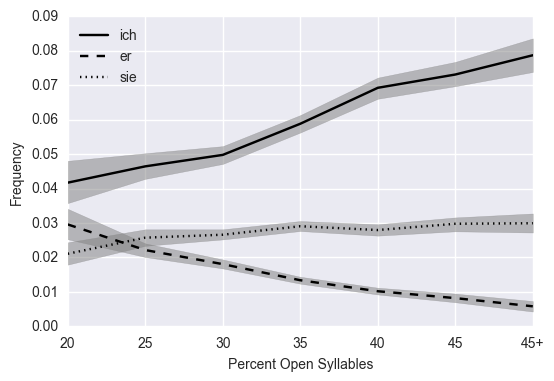

In [19]:
ich_array = [np.percentile(bootstrapped[x]["ich"], 50) for x in ordered_keys]
er_array = [np.percentile(bootstrapped[x]["er"], 50) for x in ordered_keys]
sie_array = [np.percentile(bootstrapped[x]["sie"], 50) for x in ordered_keys]
du_array = [np.percentile(bootstrapped[x]["dû"], 50) for x in ordered_keys]
wir_array = [np.percentile(bootstrapped[x]["wir"], 50) for x in ordered_keys]

arrays = [('ich', ich_array, '-'), ('er', er_array, '--'), ('sie', sie_array, ':')]

fig = plt.figure()
plt.xlabel('Percent Open Syllables', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.gca().set_xlim([.2,.5])



lines = []
for i in range(len(arrays)):
    plt.xticks([.2, .25, .3, .35, .4, .45, .5],['20', '25', '30', '35', '40', '45', '45+'])
    line = plt.plot([.2, .25, .3, .35, .4, .45, .5], arrays[i][1], color='black', linestyle=arrays[i][2], label=arrays[i][0])
    lines.append(line[0])
    low = [np.percentile(bootstrapped[x][arrays[i][0]], 2.5) for x in ordered_keys]
    high = [np.percentile(bootstrapped[x][arrays[i][0]], 97.5) for x in ordered_keys]
    plt.fill_between([.2, .25, .3, .35, .4, .45, .5], low, high, alpha=.5, color='gray')

plt.legend(handles=lines, loc="upper left")

plt.savefig('acl-pronouns', dpi=1200)

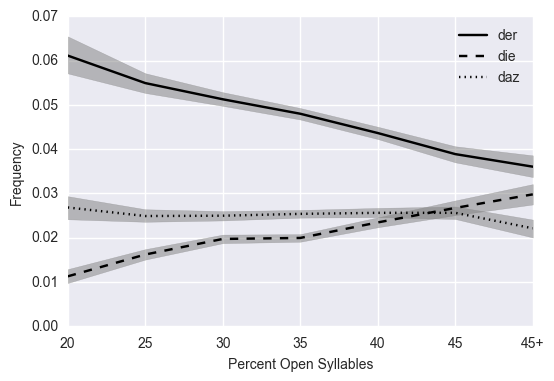

In [21]:
der_array = [np.percentile(bootstrapped[x]["der"], 50) for x in ordered_keys]
die_array = [np.percentile(bootstrapped[x]["die"], 50) for x in ordered_keys]
daz_array = [np.percentile(bootstrapped[x]["daz"], 50) for x in ordered_keys]

arrays = [('der', der_array, '-'), ('die', die_array, '--'), ('daz', daz_array, ':')]

fig = plt.figure()
plt.xlabel('Percent Open Syllables', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.gca().set_xlim([.2,.5])


lines = []
for i in range(len(arrays)):
    plt.xticks([.2, .25, .3, .35, .4, .45, .5],['20', '25', '30', '35', '40', '45', '45+'])
    line = plt.plot([.2, .25, .3, .35, .4, .45, .5], arrays[i][1], color='black', linestyle=arrays[i][2], label=arrays[i][0])
    lines.append(line[0])
    low = [np.percentile(bootstrapped[x][arrays[i][0]], 2.5) for x in ordered_keys]
    high = [np.percentile(bootstrapped[x][arrays[i][0]], 97.5) for x in ordered_keys]
    plt.fill_between([.2, .25, .3, .35, .4, .45, .5], low, high, alpha=.5, color='gray')

plt.legend(handles=lines)
    
plt.savefig('acl-articles', dpi=1200)